# DETECT DEEPFAKES NETWORK

First, we need to import the required packages

In [1]:
import torch
import torchvision
import cv2

from imutils import paths
import shutil

import torch.nn as nn
import torch.optim as optim

from torchvision import transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import os
import numpy as np
from tqdm import tqdm #to show progressive meter

We've decided to use Faceforesics' dataset which contains real and fake videos.
To download the dataset from kaggle you need to upload the .json file into the .kaggle directory or to use the function:


os.environ['KAGGLE_USERNAME'] = "username from the json file"

os.environ['KAGGLE_KEY'] = "key from the json file"

Below, we download the dataset from kaggle and we unzip the folder in a destination directory.

In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
os.environ['KAGGLE_USERNAME'] = "insert your kaggle username"
os.environ['KAGGLE_KEY'] = "insert your kaggle key"

!kaggle datasets download -d sorokin/faceforensics

100% 8.38G/8.40G [01:06<00:00, 169MB/s]
100% 8.40G/8.40G [01:06<00:00, 136MB/s]


In [4]:
!mkdir /content/data

!unzip faceforensics.zip -d /content/data

Output streaming troncato alle ultime 5000 righe.
  inflating: /content/data/manipulated_sequences/Deepfakes/c23/videos/000_003.mp4  
  inflating: /content/data/manipulated_sequences/Deepfakes/c23/videos/001_870.mp4  
  inflating: /content/data/manipulated_sequences/Deepfakes/c23/videos/002_006.mp4  
  inflating: /content/data/manipulated_sequences/Deepfakes/c23/videos/003_000.mp4  
  inflating: /content/data/manipulated_sequences/Deepfakes/c23/videos/004_982.mp4  
  inflating: /content/data/manipulated_sequences/Deepfakes/c23/videos/005_010.mp4  
  inflating: /content/data/manipulated_sequences/Deepfakes/c23/videos/006_002.mp4  
  inflating: /content/data/manipulated_sequences/Deepfakes/c23/videos/007_132.mp4  
  inflating: /content/data/manipulated_sequences/Deepfakes/c23/videos/008_990.mp4  
  inflating: /content/data/manipulated_sequences/Deepfakes/c23/videos/009_027.mp4  
  inflating: /content/data/manipulated_sequences/Deepfakes/c23/videos/010_005.mp4  
  inflating: /content/data

----------------------------------------
# TRAINING AND VALIDATION SET

Then we divide the dataset in training and validation set. In order to do this, we define training and validation paths and the percentage of videos we want in our validation set. We decide to take only 500 videos from the dataset due to memory limitations.

In [5]:
# specify path to the dataset
DATASET_PATH = "/content/data"

# specify the paths to our training and validation set
TRAIN = "train"
VALIDATION = "val"

# split of validation set
VAL_SPLIT = 0.2

Below, we have the copy_videos() function, which takes as input the list of paths (in DATASET_PATH) and a destination folder for our videos. 

In [6]:
def copy_videos(videoPaths, folder, Set):

  if not os.path.exists(folder):
    os.makedirs(folder)
  
  number = 0
  max_videos = 0
  
  # 200 videos for training for each type (altered and original)
  if folder=='train':
    max_videos = 500*(1-VAL_SPLIT)/2
  # 50 videos for validation for each type (altered and original)
  else:
    max_videos = 500*VAL_SPLIT/2
  
  while(number<max_videos):

    path = videoPaths[number]
    # grab image name and its label from the path and create
		# a placeholder corresponding to the separate label folder
    videoName = path.split(os.path.sep)[-1]
    labelFolder = os.path.join(folder, Set)
		
    # check to see if the label folder exists and if not create it
    if not os.path.exists(labelFolder):
      os.makedirs(labelFolder)
		
    # construct the destination image path and copy the current
		# image to it
    destination = os.path.join(labelFolder, videoName)
    shutil.copy(path, destination)
  
    number+=1

We load all the image paths and we randomly shaffle them. Then, we generate training and validation paths.

In [7]:
# load all altered image paths and randomly shuffle them
print("[INFO] loading video paths...")
videoAlteredPaths = list(paths.list_files(DATASET_PATH+'/manipulated_sequences/Deepfakes/c23/videos'))
np.random.shuffle(videoAlteredPaths)

# generate altered training and validation paths
valAlteredPathsLen = int(len(videoAlteredPaths) * VAL_SPLIT)
trainAlteredPathsLen = len(videoAlteredPaths) - valAlteredPathsLen
trainPaths = videoAlteredPaths[:trainAlteredPathsLen]
valPaths = videoAlteredPaths[trainAlteredPathsLen:]

# copy the altered training and validation images to their respective
# directories
print("[INFO] copying training and validation altered videos...")
copy_videos(trainPaths, TRAIN, "altered")
copy_videos(valPaths, VALIDATION, "altered")

# load all the original image paths and randomly shuffle them
print("[INFO] loading video paths...")
videoOriginalPaths = list(paths.list_files(DATASET_PATH+'/original_sequences/youtube/c23/videos'))
np.random.shuffle(videoOriginalPaths)

# generate original training and validation paths
valOriginPathsLen = int(len(videoOriginalPaths) * VAL_SPLIT)
trainOriginPathsLen = len(videoOriginalPaths) - valOriginPathsLen
trainPaths = videoOriginalPaths[:trainOriginPathsLen]
valPaths = videoOriginalPaths[trainOriginPathsLen:]

# copy the original training and validation images to their respective
# directories
print("[INFO] copying training and validation original videos...")
copy_videos(trainPaths, TRAIN, "original")
copy_videos(valPaths, VALIDATION, "original")

[INFO] loading video paths...
[INFO] copying training and validation altered videos...
[INFO] loading video paths...
[INFO] copying training and validation original videos...


----------------------------------------
# OPTICAL FLOW EXTRACTION

Once we've copied our files in training and validation folders, we can preprocess the videos.
First, we create some directories to store our optical flow and bgr frames.

In [8]:
opticalPath = "/content/optical_flow_and_bgr/"

In [9]:
if not os.path.exists(opticalPath):
  os.makedirs(opticalPath)
  os.makedirs(opticalPath+"training/original")
  os.makedirs(opticalPath+"training/altered")
  os.makedirs(opticalPath+"validation/original")
  os.makedirs(opticalPath+"validation/altered")

Before computing the optical flow we detect the faces for each frame and we crop them. Otherwise, the computation will be too slow and too heavy.

Below, we present the function which is meant to detect the faces in a given frame. We decide to use a Haar feature-based cascade classifiers to do this. The function returns a crop of the image around the face.

In [10]:
def detect_face(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt2.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5)  

    if (len(faces) == 0):
        return None
    
    for (x, y, w, h) in faces:
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    
    return gray[y - 40 : y + w + 40, x - 40 : x + h + 40]

We then define a way to compute the optical flow for training and validation set. We use the Flow Farneback method and we save the results in the created directories.

In [11]:
def compute_optical_flow(prvs, nxt, number, name, Set=None):
    
    # Creates an array filled with zero 
    # with the same dimensions of the frame
    bgr_image = cv2.cvtColor(prvs, cv2.COLOR_GRAY2BGR)
    hsv = np.zeros_like(bgr_image)
    hsv[..., 1] = 255

    # Compute the optical flow
    flow = cv2.calcOpticalFlowFarneback(prvs, nxt, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    
    # Magnitude and angle of the 2D vectors
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # Sets image hue and value according to the optical flow direction
    # and magnitude, then converts HSV to RGB (BGR) color representation
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    plt.imsave(opticalPath+'{}/{}-{}.png'.format(Set,name,number),bgr)
      

Now, we define the function where we extract the frame from the training/validation videos and where we compute the optical flow.
Then, we call it. 

For both training and validation set we compute and save the optical flow of three random pair of frames for each video. This because we can't extract every frame from each video or we will run out of memory.

Moreover, we also need to train our network with the bgr frames, otherwise the system will not be trained properly. Thus, we save the bgr cropped faces.

In [12]:
def frames(path,Set):
    
    video = cv2.VideoCapture(path)
    # name of the video
    path = path.split('/')[1]+'/'+ path.split('/')[2][0:-4]

    number = 0
    while(number<3):
        
        ret, old_frame = video.read()
        if not ret:
            return

        ret, new_frame = video.read()
        if not ret:
            break

        face1 = detect_face(old_frame)
        face2 = detect_face(new_frame)

        try:
            face1 = cv2.resize(face1, (300, 300), interpolation = cv2.INTER_AREA)
            face2 = cv2.resize(face2, (300, 300), interpolation = cv2.INTER_AREA)
            compute_optical_flow(face1, face2, number, path, Set)
            
        except Exception as e:
            continue
        
        # skip 20 frames to give randomness
        for i in range(0,20,1):
            video.read()
        
        face1_bgr = cv2.cvtColor(face1, cv2.COLOR_GRAY2BGR)
        face2_bgr = cv2.cvtColor(face2, cv2.COLOR_GRAY2BGR)

        plt.imsave(opticalPath+'{}/{}-bgr1-{}.png'.format(Set, path, number), face1_bgr)
        plt.imsave(opticalPath+'{}/{}-bgr2-{}.png'.format(Set, path, number), face2_bgr)
        number +=1

    video.release()

Execute this cell only one time, otherwise the program will extract the frames again. We compute and save the optical flow and the bgr frames for training and validation.

In [13]:
videoTrainPaths = list(paths.list_files(TRAIN))
print("Extracting training frames:")
for i in tqdm(videoTrainPaths):
  frames(i,'training')
videoValPaths = list(paths.list_files(VALIDATION))
print("Extracting validation frames:")
for i in tqdm(videoValPaths):
  frames(i,'validation')

Extracting training frames:


100%|██████████| 400/400 [17:56<00:00,  2.69s/it]


Extracting validation frames:


100%|██████████| 100/100 [06:20<00:00,  3.80s/it]


-------------------------------------------------------------------------------
# LOAD THE DATA

We then define some transformations and we use ImageFolder to load the data.

We use some data augmentation techniques on the training data and we normalize the validation data.

In [14]:
from torchvision.transforms.transforms import RandomHorizontalFlip
train_tran = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        transforms.RandomResizedCrop(size=300),
        transforms.RandomHorizontalFlip()
])
val_tran = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
trainDataset=ImageFolder('/content/optical_flow_and_bgr/training',transform=train_tran)
valDataset=ImageFolder('/content/optical_flow_and_bgr/validation',transform=val_tran)

Below, we define batch size and the device. Subsequently, we use DataLoader, which represents a Python iterable over our datasets. Our classes (altered and original) are inside class_names.
We chose 128 as batch size because it was the one that performed better.

In [15]:
BATCH_SIZE=128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_loader=DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader=DataLoader(valDataset,batch_size=BATCH_SIZE)
class_name = trainDataset.classes

-------------------------------------------------------------------------------
# PLOT A BATCH

If you want to visualize a batch of data, you can run this function. This works also at test time, plotting the prediction.

If you decide to change the batch size, you must modify the parameters of the add_subplot() function, otherwise it will throw an error.

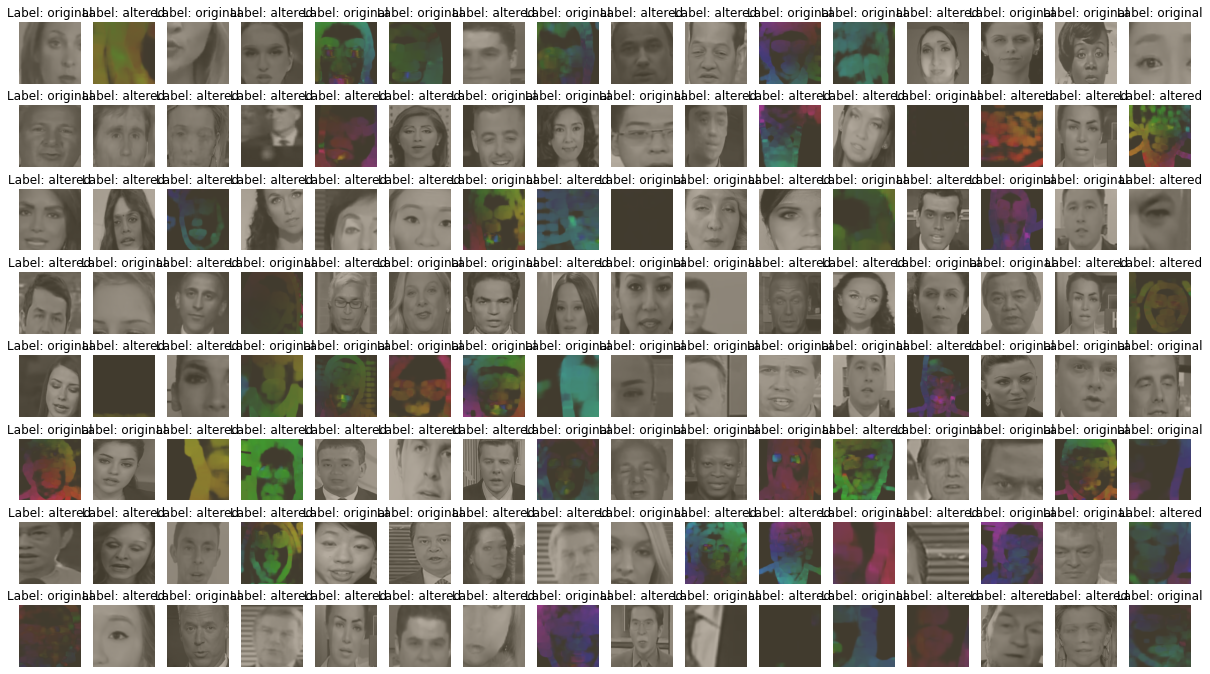

In [16]:
def show(imgs,labels,predictions=None):
  total = 0
  good = 0
  fig = plt.figure(figsize=(21,12))

  # iterate over the batch, we plot one image at a time with its label
  for i,img in enumerate(imgs):
    total +=1
    fig.add_subplot(8,16, i+1)
    label=labels[i] # actual label of the image
    
    # this code runs only when we have a prediction for our batch
    if predictions==None:
      title="Label: {0}".format(class_name[label])
    else:
      prediction=predictions[i] # prediction done by our model
      title="prediction: {0}\nlabel:{1}".format(class_name[prediction],class_name[label])
      if class_name[label] == class_name[prediction]:
        good +=1
    
    plt.title(title)
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1) # clip values outside the interval 
    plt.axis("off")
    plt.imshow(img)
  
plt.show()

inputs, classes = next(iter(train_loader))

show(inputs,classes)

-------------------------------------------------------------------------------
# TRAIN FUNCTION

This is the function which is responsible to train the model. It takes in input the model which is -in our case- a pretrained one, the loss, the dataloader, the optimizer and the number of the current epoch.

We store the losses and the accuracies inside a dictionary.

We set the number of epochs at 8. We initially tried with 20 epochs but the model overfitted the data after 8/9 epochs. We performed early stopping.

In [17]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=8

In [18]:
def train(model,loss_fn,dataloader,optimizer,epoch):
  print(f'Epoch {epoch}/{epochs}')

  model.train() # model in train mode
  
  total_loss=0    
  correct=0
  total=0

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device) # takes inputs and classes from the train dataset
    
    outputs=model(inputs) # prediction of the model
    
    loss=loss_fn(outputs,labels) # loss function
    
    optimizer.zero_grad() # gradient to zero
    loss.backward() # backward passes
    optimizer.step()

    total_loss += loss.item()
    
    ret, predicted = outputs.max(1) # prediction
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  accuracies['train'].append(accuracy)
  losses['train'].append(loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

-------------------------------------------------------------------------------
# VALIDATION FUNCTION

The val_model function is similar to the train_model function, but we do not update the weigths. At the beginning of the function we set the model to evalution mode.

In [19]:
def validation(model,loss_fn,dataloader,epoch):
  model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      ret, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Validation Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

-------------------------------------------------------------------------------
# SETUP THE MODEL

Below, we setup the model. We load a pretrained model and we reset the final fully connected layer.
We use SDG with a small learning rate (we're just fine tuning) and momentum.

In [20]:
model = torchvision.models.resnet18(pretrained=True)

# change only the last FC layer
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

-------------------------------------------------------------------------------
# TRAIN THE MODEL

We train and evaluate the model for each batch.

In [21]:
for epoch in range(1,epochs+1): 
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  validation(model,loss_fn,val_loader,epoch)

Epoch 1/8


100%|██████████| 29/29 [00:45<00:00,  1.55s/it]


Train Loss: 0.684 | Accuracy: 55.278


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Test Loss: 0.634 | Accuracy: 58.778
Epoch 2/8


100%|██████████| 29/29 [00:44<00:00,  1.54s/it]


Train Loss: 0.629 | Accuracy: 63.417


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Test Loss: 0.563 | Accuracy: 62.333
Epoch 3/8


100%|██████████| 29/29 [00:44<00:00,  1.55s/it]


Train Loss: 0.570 | Accuracy: 69.583


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Test Loss: 0.521 | Accuracy: 64.333
Epoch 4/8


100%|██████████| 29/29 [00:44<00:00,  1.54s/it]


Train Loss: 0.518 | Accuracy: 71.611


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Test Loss: 0.483 | Accuracy: 66.222
Epoch 5/8


100%|██████████| 29/29 [00:44<00:00,  1.54s/it]


Train Loss: 0.482 | Accuracy: 74.194


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Test Loss: 0.415 | Accuracy: 72.889
Epoch 6/8


100%|██████████| 29/29 [00:46<00:00,  1.61s/it]


Train Loss: 0.443 | Accuracy: 75.833


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Test Loss: 0.413 | Accuracy: 73.556
Epoch 7/8


100%|██████████| 29/29 [00:45<00:00,  1.55s/it]


Train Loss: 0.427 | Accuracy: 75.917


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Test Loss: 0.434 | Accuracy: 72.000
Epoch 8/8


100%|██████████| 29/29 [00:45<00:00,  1.57s/it]


Train Loss: 0.399 | Accuracy: 78.556


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]

Test Loss: 0.368 | Accuracy: 76.000


--------------------------------------------------------------------------------
# GRAPHS

We can plot training and validation loss/accuracy for each batch.

We want increasing training and validation accuracies and decreasing training and validation losses.

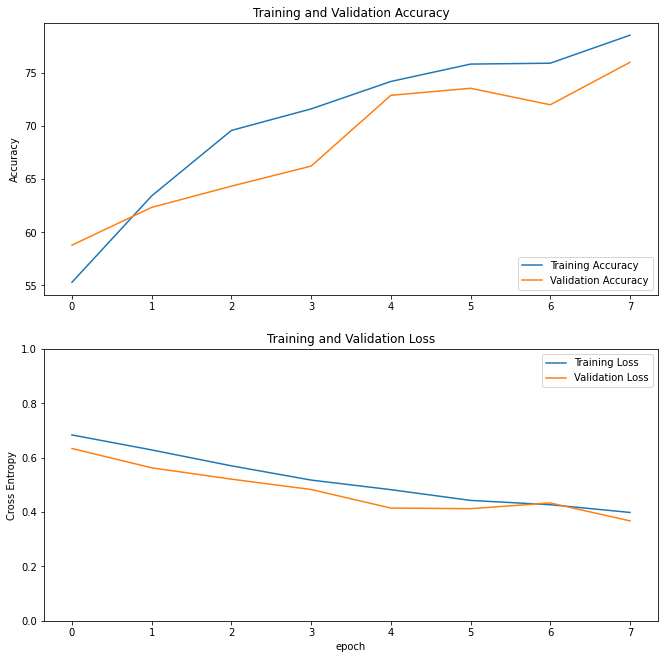

In [39]:
plt.figure(figsize=(11, 11))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

-------------------------------------------------------------------------------
# USER'S FUNCTIONS

We define user_compute_optical_flow() and detect_frames() functions for a user that wants to upload a video, compute its optical flow and save it in a specific directory.

Unlike the previous functions for training and validation data, these functions extract all the frames of the given video.

To obtain the prediction at test time we just use optical flow, we do not save bgr frames.

In [23]:
!kaggle datasets download -d stefanoservillo/testvideos

!unzip testvideos.zip

100% 4.25M/4.25M [00:00<00:00, 36.8MB/s]
100% 4.25M/4.25M [00:00<00:00, 36.7MB/s]
Archive:  testvideos.zip
  inflating: Test/Fake.mp4           
  inflating: Test/Original.mp4       


--------------------------------------------------------------------------------
# FIRST VIDEO
This video is fake but our model doesn't know it. We receive a prediction based on how many frames in the model are fake.

If you want to try training the model with different parameters, when you test it on the video make sure to run again the first cell below. Otherwise you could get the prediction of the fake test video. 

In [24]:
# original video
directory="finalVideo"
original_video='/content/Test/Original.mp4'

In [25]:
os.makedirs(directory+"/video")

In [26]:
def user_compute_optical_flow(prvs, nxt, number, name):
    
    # Creates an array filled with zero 
    # with the same dimensions of the frame
    rgb_image = cv2.cvtColor(prvs, cv2.COLOR_GRAY2BGR)
    hsv = np.zeros_like(rgb_image)
    hsv[..., 1] = 255

    # Compute the optical flow
    flow = cv2.calcOpticalFlowFarneback(prvs, nxt, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    
    # Magnitude and angle of the 2D vectors
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # Sets image hue and value according to the optical flow direction
    # and magnitude, then converts HSV to RGB (BGR) color representation
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    plt.imsave('/content/'+directory+'/video/{}-{}.png'.format(name,number),bgr)

In [27]:
def detect_frames(path):
    video = cv2.VideoCapture(path)
    ret, old_frame = video.read()
    if not ret:
        print('No frames')
        return
    face1 = detect_face(old_frame)
    path = path.split('/')[3][0:-4]

    number = 0
    while(video.isOpened()):
        ret, new_frame = video.read()
        if not ret:
            print("The video is finished")
            break
        face2 = detect_face(new_frame)

        try:
          face1 = cv2.resize(face1, (300, 300), interpolation = cv2.INTER_AREA)
          face2 = cv2.resize(face2, (300, 300), interpolation = cv2.INTER_AREA)
          optical_flow = user_compute_optical_flow(face1, face2, number,path)
        except Exception as e:
          continue

        old_frame = new_frame
        face1 = face2
        number +=1
    video.release()

In [28]:
# extract frames and save them
detect_frames(original_video)

The video is finished


In [29]:
def output(imgs,predictions):
  total = 0
  fake = 0
  for i, img in enumerate(imgs):
    total +=1
    prediction=predictions[i]
    if class_name[prediction] == 'altered':
      fake +=1
  return [total,fake]

In [30]:
Dataset=ImageFolder('/content/'+directory,transform=val_tran) # load the data in the dataset

In [31]:
data_loader=DataLoader(Dataset,batch_size=32)

In [32]:
def predict_images(model,images):
  model.eval()
  with torch.no_grad(): #torch.no_grad() is used to reduce memory consumptions disabled gradient calculation
    inputs = images.to(device) # add the inputs to the model
    outputs = model(inputs) # obtained the prediction of the model
    ret, preds = torch.max(outputs, 1) # returns max output with it's position
    pair = output(images, preds.cpu()) # show the results
    return pair

total=0
fake=0
for i in iter(data_loader):
  pair = predict_images(model,i[0])
  total +=pair[0]
  fake += pair[1]
percentage = (fake/total)*100
percentage = round(percentage, 2)
print("For the original video, the output is: video fake al "+ str(percentage) + '%')

For the original video, the output is: video fake al 32.79%


--------------------------------------------------------------------------------
# SECOND VIDEO
This video is fake but our model doesn't know it. We receive a prediction based on how many frames in the model are fake.

If you want to try training the model with different parameters, when you test it on the video make sure to run again the first cell below. Otherwise you could get the prediction of the original test video. 

In [33]:
# fake video
directory="finalVideo1"
fake_video='/content/Test/Fake.mp4'

In [34]:
os.makedirs(directory+"/video")

In [35]:
detect_frames(fake_video)

The video is finished


In [36]:
Dataset=ImageFolder('/content/'+directory,transform=val_tran) # load the data in the dataset

In [37]:
data_loader=DataLoader(Dataset,batch_size=BATCH_SIZE) # load the data in the data loader

In [38]:
def predict_images(model,images):
  model.eval()
  with torch.no_grad(): #torch.no_grad() is used to reduce memory consumptions disabled gradient calculation
    inputs = images.to(device) # add the inputs to the model
    outputs = model(inputs) # obtained the prediction of the model
    ret, preds = torch.max(outputs, 1) # returns max output with it's position
    pair =output(images,preds.cpu()) # show the results
    return pair

total=0
fake=0
for i in iter(data_loader):
  pair = predict_images(model,i[0])
  total +=pair[0]
  fake += pair[1]
percentage = (fake/total)*100
percentage = round(percentage, 2)
print("For the fake video the output is: Video fake al "+ str(percentage) + '%')

For the fake video the output is: Video fake al 79.47%
